In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"{tf.__version__ = }")

tf.__version__ = '2.6.1'


## Different ways to build keras models

### The squential model

In [2]:
# default
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ]
)

# using `add`

model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

2022-04-24 03:07:31.967812: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-24 03:07:32.502443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [3]:
# model.weights doen't exist until the model is built
# (when you call `build()` or pass an input)
try:
    model.weights
except ValueError as ex:
    print("Model weights haven't been initialized yet")

Model weights haven't been initialized yet


In [4]:
model.build(input_shape=(None, 3))
weights = model.weights
assert weights

for w in weights:
    print(f"name: {w.name}. shape: {w.shape}")


name: dense_2/kernel:0. shape: (3, 64)
name: dense_2/bias:0. shape: (64,)
name: dense_3/kernel:0. shape: (64, 10)
name: dense_3/bias:0. shape: (10,)


In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [6]:
# give your model and layers a name
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_dense_layer_0"))
model.add(layers.Dense(10, activation="softmax", name="my_dense_layer_1"))

model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_layer_0 (Dense)     (None, 64)                256       
_________________________________________________________________
my_dense_layer_1 (Dense)     (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [7]:
# You can get your sequential model to build on the fly by passing an `Input`
# This may be usefull if you want to call `model.summary()` before you finish building
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))

model.add(layers.Dense(64, activation="relu"))
print(model.summary())

model.add(layers.Dense(10, activation="softmax"))
print(model.summary())

# model.build((None, 3)) # no need for this any more!

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
None


### The functional API

Sequential is only good for single-input single-output model with one layer after another in a fully sequential (duh) way.

The functional API is way more powerful.

#### Simple example

Same model as before

In [8]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
# the input tensor is a "symbolic" tensor. It encodes the specifications
# of the actual tensor of data that the model will se when you use it
# "symbolic" === future tensor of data

print(f"{inputs.shape = }")
print(f"{inputs.dtype = }")

inputs.shape = TensorShape([None, 3])
inputs.dtype = tf.float32


In [10]:
# all keras Layers can be calles on "real" tensors of data and on these
# symbolic tensors. In the later case, the return is a symbolic tensor as well
# with updates shape and dtype

print(f"{features.shape = }")
print(f"{features.dtype = }")

features.shape = TensorShape([None, 64])
features.dtype = tf.float32


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


#### Multi-input Multi-output models

Lets try to build a system to rank customer support tickets by priority and route them to the appropriate department. The model will have 3 inputs:
- Title of the ticket (text*)
- Text body of the ticket (text*)
- Any tags added by the user (categorical, assumed one-hot-encoded)

*We will encode text as an array of 1s and 0s of size vocabulary_size

As for the outputs:
- The priority score will be a scalar between 0 and 1
- Department as multi-class classification output

In [12]:
vocabulary_size = 10_000
num_tags = 100
num_departments = 4

# inputs
title = keras.Input(shape=(vocabulary_size, ), name="title")
text_body = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags = keras.Input(shape=(num_tags, ), name="tags")
model_inputs = [
    title,
    text_body,
    tags,
]

# concat and apply Dense
features = layers.Concatenate(name="concat")(model_inputs)
features = layers.Dense(64, activation="relu", name="dense_features_layer")(features)

# outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features) # sigmoid to get 0-1
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# define model
model = keras.Model(
    inputs = model_inputs,
    outputs = [
        priority,
        department,
    ],
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 10000)]      0                                            
__________________________________________________________________________________________________
text_body (InputLayer)          [(None, 10000)]      0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 20100)        0           title[0][0]                      
                                                                 text_body[0][0]            

In [13]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
# department_data = np.random.randint(0, 2, size=(num_samples, num_departments)) # this yields multi-label. I want mylty-class

def get_department_data():
    random_floats = np.random.random(size=(num_samples, num_departments))
    department_data = np.zeros_like(random_floats)

    for data_row, random_row in zip(department_data, random_floats):
        data_row[random_row.argmax()]=1.

    assert (department_data.sum(axis=1) == 1.).all()

    return department_data

department_data = get_department_data()

you can train a multi-input model by calling `fit()`, caveat being you need either to pass your data in the same order as defined in the Model constructor

In [14]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

2022-04-24 03:07:34.748089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


40/40 [==============================] - 0s 3ms/step - loss: 2.7628 - priority_loss: 0.3083 - department_loss: 2.4545 - priority_mean_absolute_error: 0.4754 - department_accuracy: 0.3484


or even better leverage the names you gave the `Input`

In [15]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

inputs_dict = {
    "title" : title_data,
    "text_body" : text_body_data,
    "tags" : tags_data   ,
}

outputs_dict = {
    "priority": priority_data,
    "department": department_data
}

model.fit(inputs_dict, outputs_dict, epochs=1)

model.evaluate(inputs_dict, outputs_dict)
priority_preds, department_preds = model.predict(inputs_dict)

40/40 [==============================] - 0s 3ms/step - loss: 2.6310 - priority_loss: 0.3294 - department_loss: 2.3016 - priority_mean_absolute_error: 0.4963 - department_accuracy: 0.2836


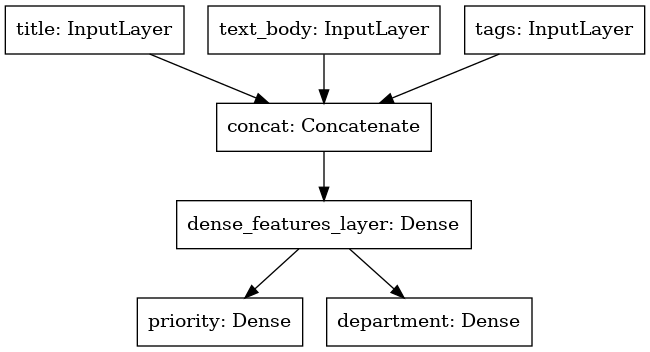

In [16]:
keras.utils.plot_model(model)

#### feature extraction

Lets say you want to add another output to the previous model: Some kind of difficulty rating with 3 categories "quick", "medium" and "difficult".

In [17]:
# you can access intermediate features from your previous model
features = model.get_layer(name="dense_features_layer").output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty]
)

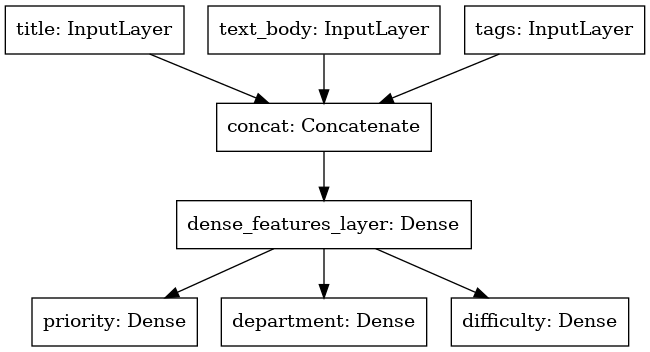

In [18]:
keras.utils.plot_model(new_model)

### Subclassing the Model Class

Lets re-implement the last model

In [19]:
class CustomTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__() ## dont forget this

        # define internal layers
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        
        # define output layers
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)

        priority = self.priority_scorer(features)
        department = self.department_classifier(features)

        return priority, department

In [20]:
model = CustomTicketModel(num_departments=4)
priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [21]:
# [1] the order is important here
model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"], #[1]
    metrics=[["mean_absolute_error"], ["accuracy"]] #[1]
)

model.fit(
    inputs_dict, # structure of the input must match exacly `inputs`
    [priority_data, department_data], # this must match exatly what the model returns. Here, a list.
    epochs=1
)

model.evaluate(
    inputs_dict,
    [priority_data, department_data], # this must match exatly what the model returns. Here, a list.
)

priority_preds, department_preds = model.predict(inputs_dict)

40/40 [==============================] - 0s 3ms/step - loss: 1.4610 - output_1_loss: 0.0833 - output_2_loss: 1.3777 - output_1_mean_absolute_error: 0.2499 - output_2_accuracy: 0.2867


Subclassing API is the most flexible. Useful when your model can't be defined as a DAG

**Beware**: funtional yields a data structure (graph). Subclassed yields bytecode, which is more flexible but as a results:
- you can not inspect a subclassed model (`summary` won't display layer connectivity and `plot_model` wont display layers at all)
- you can not access the nodes of the "graph" to do feature extraction, because there is no graph!

In [22]:
model.summary()

Model: "custom_ticket_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  1286464   
_________________________________________________________________
dense_9 (Dense)              multiple                  65        
_________________________________________________________________
dense_10 (Dense)             multiple                  260       
Total params: 1,286,789
Trainable params: 1,286,789
Non-trainable params: 0
_________________________________________________________________


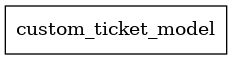

In [23]:
keras.utils.plot_model(model)

In [24]:
# let me repeat that with model outputing a dictionary

class CustomTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__() ## dont forget this

        # define internal layers
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        
        # define output layers
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)

        priority = self.priority_scorer(features)
        department = self.department_classifier(features)

        return {"priority": priority, "department": department}

model = CustomTicketModel(num_departments=4)

model.compile(
    optimizer="rmsprop",
    loss={"priority": "mean_squared_error", "department" : "categorical_crossentropy"}, #[1]
    metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]} #[1]
)

model.fit(
    inputs_dict, # structure of the input must match exacly `inputs`
    {"priority": priority_data, "department": department_data}, # this must match exatly what the model returns. Here, a list.
    epochs=1
)

model.evaluate(
    inputs_dict,
    {"priority": priority_data, "department": department_data}, # this must match exatly what the model returns. Here, a list.
)

predictions_dict = model.predict(inputs_dict)

40/40 [==============================] - 0s 3ms/step - loss: 1.4570 - department_loss: 1.3738 - priority_loss: 0.0832 - department_accuracy: 0.2609 - priority_mean_absolute_error: 0.2496


In [25]:
predictions_dict

{'priority': array([[0.5004947],
        [0.5004947],
        [0.5004947],
        ...,
        [0.5004947],
        [0.5004947],
        [0.5004947]], dtype=float32),
 'department': array([[0.24805784, 0.24675103, 0.24944372, 0.2557474 ],
        [0.24805784, 0.24675103, 0.24944372, 0.2557474 ],
        [0.24805784, 0.24675103, 0.24944372, 0.2557474 ],
        ...,
        [0.24805784, 0.24675103, 0.24944372, 0.2557474 ],
        [0.24805784, 0.24675103, 0.24944372, 0.2557474 ],
        [0.24805784, 0.24675103, 0.24944372, 0.2557474 ]], dtype=float32)}

I like this one better, although it is significantly more verbose

### Mixing and Matching different components

In [26]:
# use subclassed model in Functional API

class Classifier(keras.Model):
    """Binary or multi-class classifier"""
    def __init__(self, num_classes):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"

        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3, ))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

_ = model.predict(np.random.random(size=(num_samples, 3)))

In [27]:
# functional model as part of subclassed layer or model
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.clasifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs),
        return self.clasifier(features)

model = MyModel()

_ = model.predict(np.random.random(size=(num_samples, 64)))

### My Takeaways

use the right tool for the job. But basically if your model can be defined as a DAG, use functional API + subclassed layers

## The built in training and evaluation loops

In [3]:
from tensorflow.keras.datasets import  mnist

def get_mnist_model():
    inputs = keras.Input(shape= (28 * 28, ))
    features = layers.Dense(515, activation="relu")(inputs)
    features = layers.Dropout(.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60_000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10_000, 28 * 28)).astype("float32") / 255

train_images, val_images = images[10_000:], images[:10_000]
train_labels, val_labels = labels[10_000:], labels[:10_000]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["Accuracy"])

model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))

2022-04-29 23:49:09.946858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 23:49:15.435416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7
2022-04-29 23:49:16.957646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
1563/1563 [==============================] - 9s 3ms/step - loss: 0.2907 - Accuracy: 0.9142 - val_loss: 0.1544 - val_Accuracy: 0.9555
Epoch 2/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1656 - Accuracy: 0.9536 - val_loss: 0.1274 - val_Accuracy: 0.9663
Epoch 3/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1394 - Accuracy: 0.9625 - val_loss: 0.1170 - val_Accuracy: 0.9704


In [4]:
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

313/313 [==============================] - 0s 1ms/step - loss: 0.1091 - Accuracy: 0.9720


### Writing your own metrics

In [6]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.se_sum = self.add_weight(name="se_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # integer-label to categorical predictions
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        
        # squared error (se)
        se = tf.reduce_sum(tf.square(y_true - y_pred))
        self.se_sum.assign_add(se)

        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.se_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.se_sum.assign(0.)
        self.total_samples.assign(0)


In [7]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["Accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1287 - Accuracy: 0.9668 - rmse: 7.4058 - val_loss: 0.1048 - val_Accuracy: 0.9732 - val_rmse: 7.4292
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1166 - Accuracy: 0.9706 - rmse: 7.4149 - val_loss: 0.1077 - val_Accuracy: 0.9751 - val_rmse: 7.4361
Epoch 3/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1079 - Accuracy: 0.9740 - rmse: 7.4202 - val_loss: 0.1079 - val_Accuracy: 0.9764 - val_rmse: 7.4427


### Using callbacks

In [11]:
# early stop + checkpointing
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True
    )
]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels), callbacks=callback_list)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2956 - Accuracy: 0.9125 - val_loss: 0.1569 - val_Accuracy: 0.9558
Epoch 2/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1662 - Accuracy: 0.9542 - val_loss: 0.1197 - val_Accuracy: 0.9672
Epoch 3/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1374 - Accuracy: 0.9631 - val_loss: 0.1159 - val_Accuracy: 0.9702


In [12]:
# to reload the checkpoint
model = keras.models.load_model("checkpoint_path.keras")

### Writing your own callbacks

Epoch 1/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2943 - accuracy: 0.9129 - val_loss: 0.1664 - val_accuracy: 0.9514
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1654 - accuracy: 0.9537 - val_loss: 0.1405 - val_accuracy: 0.9617
Epoch 3/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1397 - accuracy: 0.9622 - val_loss: 0.1194 - val_accuracy: 0.9698


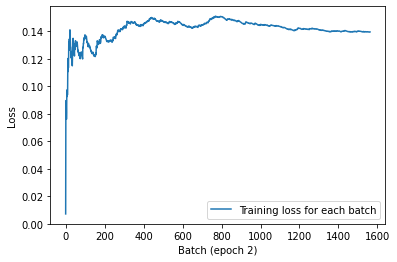

In [15]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    """generate a plot with the train loss for each batch"""
    def on_train_begin(self, logs):
        self.per_batch_loss=[]

    def on_batch_end(self, batch, logs):
        self.per_batch_loss.append(logs["loss"])

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_loss)), self.per_batch_loss, label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_loss.clear()

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels), callbacks=[LossHistory()])

### Tensorboard

In [17]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./tb_logs")
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels), callbacks=[tensorboard])

2022-04-30 00:27:13.327240: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-30 00:27:13.327277: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-30 00:27:13.448961: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-30 00:27:13.451230: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/3
   3/1563 [..............................] - ETA: 2:46 - loss: 2.2782 - accuracy: 0.2500

2022-04-30 00:27:14.037001: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-30 00:27:14.037042: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-30 00:27:14.165941: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-30 00:27:14.168291: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-04-30 00:27:14.193405: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 105 callback api events and 102 activity events. 
2022-04-30 00:27:14.196303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-30 00:27:14.200974: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tb_logs/train/plugins/profile/2022_04_30_00_27_14

2022-04-30 00:27:14.203057: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipp

1563/1563 [==============================] - 4s 3ms/step - loss: 0.2970 - accuracy: 0.9117 - val_loss: 0.1601 - val_accuracy: 0.9550
Epoch 2/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1702 - accuracy: 0.9524 - val_loss: 0.1273 - val_accuracy: 0.9643
Epoch 3/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1405 - accuracy: 0.9634 - val_loss: 0.1212 - val_accuracy: 0.9691


## Writing your own training and evaluation loops

### training vs inference

In [30]:
# training step pseudo-code
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(
            inputs, 
            training=True #puts layers (like Fropout) in training norm
            )
        loss = loss_fn(targets, predictions)
        gradients = tape.gradient(
            loss, 
            model.trainable_weights #instead of model weights, to exclude non-trainable weights like BatchNorm moving averages
            )
        optimizer.apply_gradients(zip(model.trainable_weights, gradients))

### low-level usage of metrics

In [18]:
metrics = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metrics.update_state(targets, predictions)
current_result = metrics.result()
print(f"{current_result = }")

current_result = <tf.Tensor: shape=(), dtype=float32, numpy=1.0>


In [19]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)

print(f"{mean_tracker.result() = }")

mean_tracker.result() = <tf.Tensor: shape=(), dtype=float32, numpy=2.0>


remember to call `metric.reset_state()` when you want to reset (start of epoch or start of eval)

### Complete training and evaluation loop

In [31]:
model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metrics = keras.metrics.Mean()

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metrics.update_state(loss)
    logs["loss"] = loss_tracking_metrics.result()
    return logs

def reset_metrics():
    """Utility script to reset all metrics"""
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metrics.reset_state()


In [32]:
training_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
epochs = 3

for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_ds:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}: ")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")


Results at the end of epoch 0: 
...sparse_categorical_accuracy: 0.9153
...loss: 0.2872
Results at the end of epoch 1: 
...sparse_categorical_accuracy: 0.9546
...loss: 0.1637
Results at the end of epoch 2: 
...sparse_categorical_accuracy: 0.9631
...loss: 0.1402


### Make it fast with tf.function

Notice that manual loop took 52.6s while the previous `.fit` ones were taking 12s. Go back and add `@tf.function` to compile it. Now it took 7.3s !!!! :brain-explodes:

### Leveraging fit() with a custom training loop

Create a new class that subclasses keras.Model, override `train_step` method (and maybe the `metrics` property if you won't mass metrics to compile), and instantiate it functional-API style

In [35]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        """
        you need to pass the metrics you want reset this if you don't pass metrics to compole
        """
        return [loss_tracker]

In [36]:
inputs = keras.Input(shape= (28 * 28, ))
features = layers.Dense(515, activation="relu")(inputs)
features = layers.Dropout(.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer="rmsprop") #we already defined loss and metrics in the CustomModel
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2946
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1651
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1371


after you call compile(), you get access to:
- `self.compiled_loss`
- `self.compiled_metrics` wrapper around the list of metrics, you can do self.compiled_metrics.update_state() to update all
- `self.metrics` actual list of metrics you passed to compile. It also includes the metric to track the loss.

In [41]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions) # <------

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions) # <-----
        return {m.name: m.result() for m in self.metrics} # < -------

In [42]:
inputs = keras.Input(shape= (28 * 28, ))
features = layers.Dense(515, activation="relu")(inputs)
features = layers.Dropout(.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2948 - accuracy: 0.9122
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1606 - accuracy: 0.9551
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1391 - accuracy: 0.9626
